### Import packages

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.pipeline import Pipeline

### Set-up

In [3]:
infile = 'https://www.dropbox.com/s/6grsxawwozuz661/credit_default_model_data.csv?dl=1'

target = 'default payment next month'

### Read data

In [4]:
df = pd.read_csv(infile)

y = df[target]
X = df.drop(target, axis=1)

del df

In [5]:
X.head()

,Unnamed: 0,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,pay_bucket_7_flag,pay_bucket_8_flag,pay_bucket_neg1_flag,pay_bucket_neg2_flag,pay_amt_total,bill_amt_total,pay_to_billed_ratio,zero_bill_amount,utilization_avg,utilization_max
0,0,20000,24,3913,3102,689,0,0,0,0,...,0,0,1,1,689,7704,0.089434,0,0.064200,0.195650
1,1,120000,26,2682,1725,2682,3272,3455,3261,0,...,0,0,1,0,5000,17077,0.292791,0,0.023718,0.028792
2,2,90000,34,29239,14027,13559,14331,14948,15549,1518,...,0,0,0,0,11018,101653,0.108388,0,0.188246,0.324878
3,3,50000,37,46990,48233,49291,28314,28959,29547,2000,...,0,0,0,0,8388,231334,0.036259,0,0.771113,0.985820
4,4,50000,57,8617,5670,35835,20940,19146,19131,2000,...,0,0,1,0,59049,109339,0.540054,0,0.364463,0.716700


In [6]:
X = X[X.columns[1:]]

In [7]:
X.shape

(30000, 55)

In [8]:
y.mean()

0.2212

### Train-Test partition

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20000, random_state=314)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=10000, random_state=314)

len(X_train), len(X_test), len(X_valid)

(10000, 10000, 10000)

### Logistic Regression model

In [10]:
logit = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=314)

Standardize the input data.

In [11]:
X_scaler = StandardScaler()

# Fit and transform the training data frame
X_train_std = X_scaler.fit_transform(X_train.astype(float))

# Transform the test data frame
X_test_std = X_scaler.transform(X_test.astype(float))

Fit the model and get model scores.

In [12]:
logit.fit(X_train_std, y_train)

logit_scores_train = logit.predict_proba(X_train_std)[:, 1]
logit_scores_test = logit.predict_proba(X_test_std)[:, 1]

ROC Curve

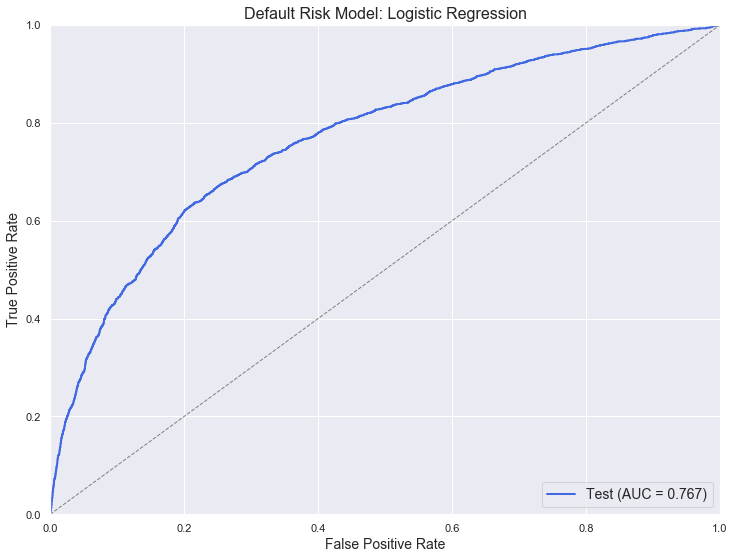

In [13]:
logit_fpr_test, logit_tpr_test, _ = roc_curve(y_test, logit_scores_test)

sns.set(style="darkgrid")

plt.figure().set_size_inches(12, 9)

plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2, linestyle = '-',
         label='Test (AUC = %0.3f)' %roc_auc_score(y_test, logit_scores_test))


plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Logistic Regression', fontsize = 16)
plt.legend(loc="lower right", fontsize = 14);

### Principal Component Analysis (PCA)

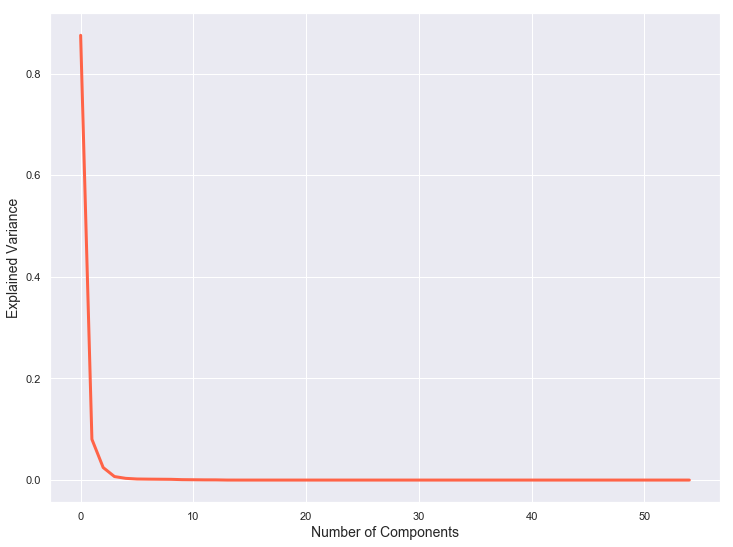

In [14]:
pca = PCA(random_state=314)

pca.fit(X_train)

plt.figure().set_size_inches(12, 9)

sns.lineplot(x=range(len(X.columns)), y=pca.explained_variance_ratio_, linewidth=3, color='tomato')
plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14);

Cumulative Variance Explained

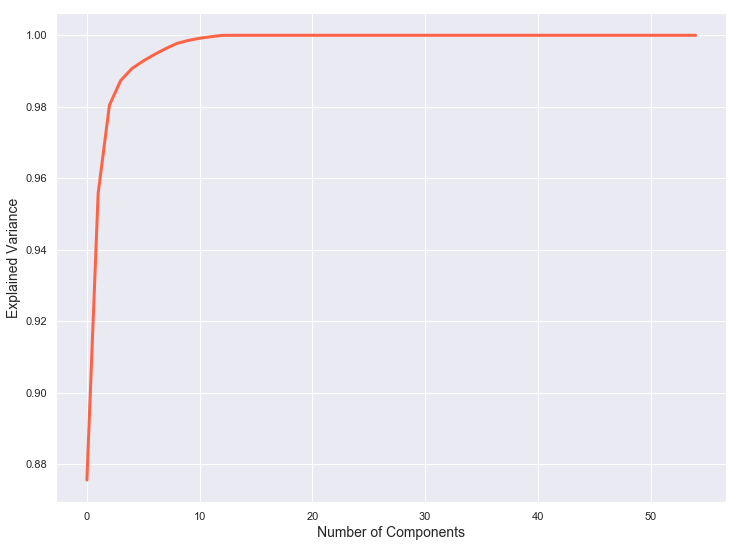

In [15]:
plt.figure().set_size_inches(12, 9)

sns.lineplot(x=range(len(X.columns)), y=np.cumsum(pca.explained_variance_ratio_), linewidth=3, color='tomato')
plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14);

A very few principal compoents appear to explain most of the variance in the data. The top ten principal components explain almost 100% of all variance!

We need to *standardize* the data before fitting PCA!

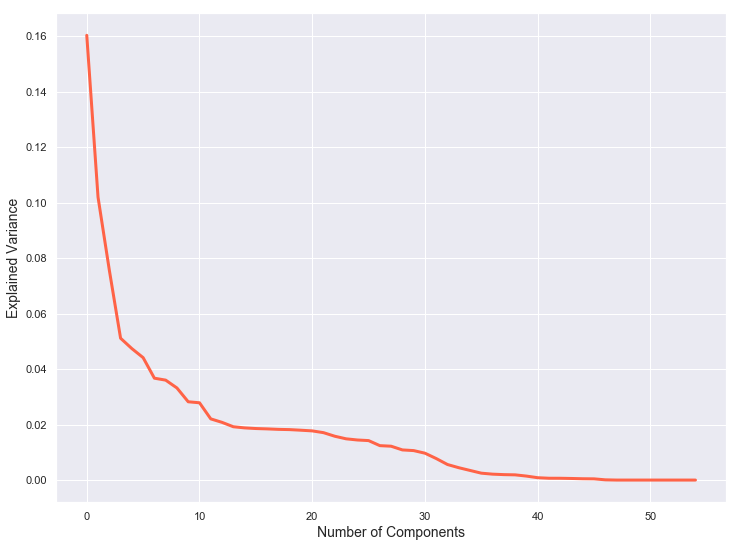

In [16]:
pca.fit(X_train_std)

plt.figure().set_size_inches(12, 9)

sns.lineplot(x=range(len(X.columns)), y=pca.explained_variance_ratio_, linewidth=3, color='tomato')

plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14);

Cumulative Variance Explained

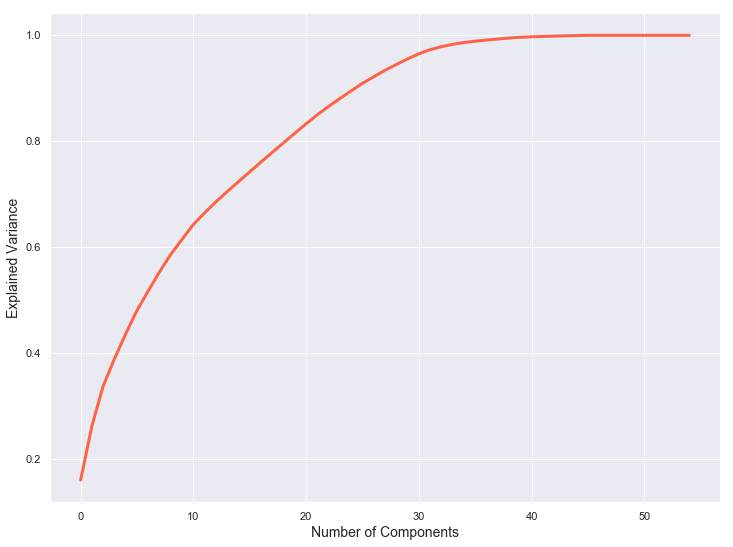

In [17]:
plt.figure().set_size_inches(12, 9)

sns.lineplot(x=range(len(X.columns)), y=np.cumsum(pca.explained_variance_ratio_), linewidth=3, color='tomato')
plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14);

In [18]:
np.cumsum(pca.explained_variance_ratio_)[30]

0.9650993590329742

Let's keep the top 30 principal compoents. By doing so, we will retain 97% of the total variance.

In [35]:
components_to_keep = 30

pca = PCA(n_components=components_to_keep, random_state=314)

### Pipelines

In [33]:
# Define the pipeline
pl = Pipeline(steps=[('scaling', X_scaler),
                     ('pca', pca),
                     ('logit', logit)])

# Fit the pipeline
pl_fit = pl.fit(X_train.astype(float), y_train)

# Calculate model scores (predicted probabilities)
pl_scores_test = pl_fit.predict_proba(X_test.astype(float))[:, 1]

ROC Curve

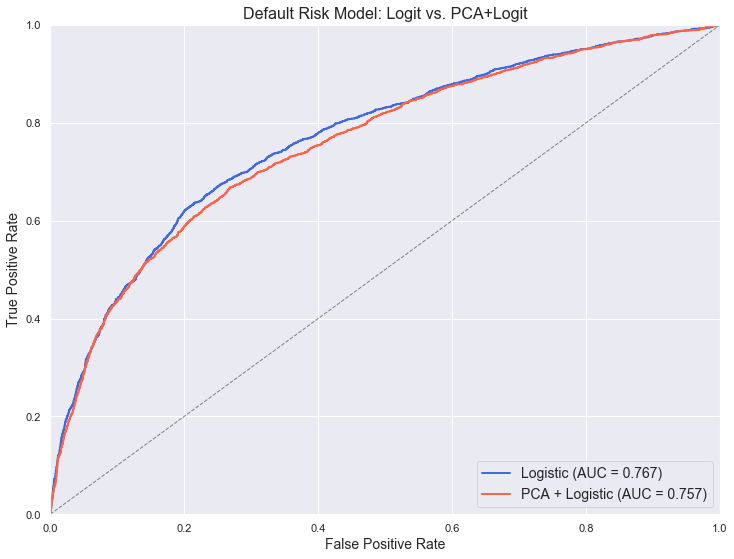

In [34]:
pl_fpr_test, pl_tpr_test, _ = roc_curve(y_test, pl_scores_test)

sns.set(style="darkgrid")

plt.figure().set_size_inches(12, 9)

plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2, linestyle = '-',
         label='Logistic (AUC = %0.3f)' %roc_auc_score(y_test, logit_scores_test))

plt.plot(pl_fpr_test, pl_tpr_test, color='tomato', lw=2, linestyle = '-',
         label='PCA + Logistic (AUC = %0.3f)' %roc_auc_score(y_test, pl_scores_test))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Logit vs. PCA+Logit', fontsize = 16)
plt.legend(loc="lower right", fontsize = 14);

Why did the performance of the model didn't improve?

What would happen if we keep *all* principal components?

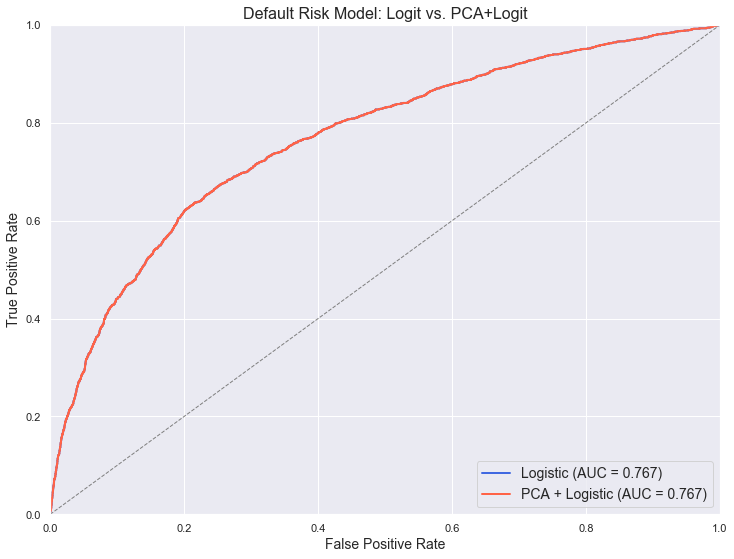

In [22]:
pca = PCA(random_state=314)

# Define the pipeline
pl = Pipeline(steps=[('scaling', X_scaler),
                     ('pca', pca),
                     ('logit', logit)])

# Fit the pipeline
pl_fit = pl.fit(X_train.astype(float), y_train)

# Calculate model scores (predicted probabilities)
pl_scores_test = pl_fit.predict_proba(X_test.astype(float))[:, 1]

# ROC Curve
pl_fpr_test, pl_tpr_test, _ = roc_curve(y_test, pl_scores_test)

sns.set(style="darkgrid")

plt.figure().set_size_inches(12, 9)

plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2, linestyle = '-',
         label='Logistic (AUC = %0.3f)' %roc_auc_score(y_test, logit_scores_test))

plt.plot(pl_fpr_test, pl_tpr_test, color='tomato', lw=2, linestyle = '-',
         label='PCA + Logistic (AUC = %0.3f)' %roc_auc_score(y_test, pl_scores_test))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Logit vs. PCA+Logit', fontsize = 16)
plt.legend(loc="lower right", fontsize = 14);